In [75]:
import numpy as np
import numpy_groupies as npg
import scipy.sparse as sps
import numpy.matlib as npm
import cvxpy as cp
import scipy.io
import networkx as nx
import matplotlib.pyplot as plt
import optimize_laplacian_gaussian as ogl
import Metrics 
import SyntheticDataGenerator as SDG

In [41]:
def graph_learning_gaussian_regressor(X_noisy, param):
    
    N = param['N']
    max_iter = param['max_iter']
    alpha = param['alpha']
    beta = param['beta']

    objective = [0]*max_iter
    Y_0 = X_noisy
    Y = Y_0
    R = np.zeros(Y.shape)
    for i in range(max_iter):
        
        # Step 1: given Y and R, update L
        # This is the same as Step 1 of Dong's algorithm
        # with Y = Y-R
        L = ogl.optimize_laplacian_gaussian(N,(Y-R),alpha,beta)
        
        # Step 2: given L and R, update Y
        # Note if we expand the quadratic form 
        # we get a constant term with L and R, so
        # the optimization is identical to Dong's second
        # Step.
        temp = np.linalg.cholesky(np.identity(N) + alpha*L)
        temp_t = np.transpose(temp)
        arg1 = np.linalg.lstsq(temp_t, (Y_0-R))[0]
        Y = np.linalg.lstsq(temp, arg1)[0]
        
        # Step 3: Given L and Y, update R
        R = Y_0 - Y
        # Store objective
        arg1 = np.linalg.norm(Y_0 - (Y+R), 'fro')**2 
        arg2 = alpha*np.trace(np.transpose(Y)@L@Y)
        arg3 = beta*np.linalg.norm(L, 'fro')**2
        objective[i] = arg1 + arg2 + arg3
        
        # Stopping criteria
        if i>=2 and abs(objective(i) - objective(i-1)) < 10**(-4):
            print(str(i) + ' iterations needed to converge.')
            break
        return([L.round(4), Y.round(4), R.round(4)])
# Generates Synthetic data following Dongs Model
# with an added regression term
# Generate an num_signalsXnum_Vertices matrix of synthetic data
# over a graph G following Dong's model. 
# mu := mean; sigma := standard deviation
def RandomRegressorSignal(graph, mu, sigma, b, P, seed):
    # The Graph Laplacian
    L = nx.laplacian_matrix(graph).toarray()
    
    # The number of vertices
    size = L.shape[0]
    
    if(size != P[0].shape[0]):
        print("Number vertices does not equal number of rows in P.")
        return
    if(P[0].shape[1] != b.shape[0]):
        print("Number of columns of P[i] is not equal to number of rows of b.")
        return
    
    # Normalized Laplacian ie tr(L) = num_vertices
    NormL = (size/np.trace(L))*L
    
    # Moore Penrose Psudoinverse
    MPPI = np.linalg.pinv(NormL, hermitian= True)
    
    # Vector of means
    mean = mu*np.ones(size)
    
    # Matrix of standard deviation
    stan_dev = MPPI + sigma*np.diag(np.ones(size))
    X = []
    np.random.seed(seed)
        
    # Create random regression coefficients 
    #b = np.random.rand(observations,)
    #b = np.full(shape=observations, fill_value=1, dtype=np.int)
    for i in range(len(P)):
        np.random.seed(seed + i)
        signal = np.random.multivariate_normal(mean, stan_dev) + P[i]@b
        X.append(signal.tolist())
    return np.matrix(np.transpose(X))

# Generates synthetic data of a specific distribution
# num_observations: Length of the column
# distribution:     (string) Type of distribution 
# parameters:       (string) Parameters for the distribution 
# Example:          generate_data_type(1,1,'uniform', '0,1')
def generate_data_type(num_observation, distribution, parameters, seed):
    rand = np.random.RandomState(seed)
    data_table = []
    x = eval('rand.'+distribution+'('+parameters+', '+str(num_observation)+')')
    x = [i for i in x]
    data_table.append(x)
    return(np.transpose(np.matrix(data_table)))

# Uses generate_data_type to create synthetic data for numerous 
# distributions
# num_observations: (Int) Length of a row in the table
# predictors_vec:   (list<int>) Number of predictors of a given distribution
# type.
# distributions:    (list<str>) List of the distribution types in the data
# parameters:       (list<list><str>) List of parameters for corresponding distirbution
def generate_experiment(num_observations, distributions, parameters, seed):
    s = seed
    M_shape = (num_observations, sum([len(i) for i in parameters]))
    Ptemp = [i for i in parameters]
    M = generate_data_type(num_observations, distributions[0], Ptemp[0][0], s)
    Ptemp[0] = Ptemp[0][1:len(Ptemp)]
    for i in range(len(Ptemp)):
        for p in Ptemp[i]:
            s = s + 1
            temp = generate_data_type(num_observations, distributions[i], p, s)
            M = np.concatenate((M,temp))
    M = np.reshape(M, M_shape, 'F')
    return(M)
def generate_trials(num_observations, num_trials, distributions, parameters, seed):
    s = seed
    T = []
    for i in range(num_trials):
        P = generate_experiment(num_observations, distributions, parameters, s)
        T.append(P)
    return(T)

In [17]:
seed = 123
num_obser = 20
num_trials = 100
G = nx.erdos_renyi_graph(num_obser, 0.2)
# dist_vec = ['uniform', 'normal', 'binomial']
dist_vec = ['uniform']
# param_vec = [['0,1'], ['0,.5', '0,.5'], ['1,.5']]
param_vec = [['0,1']]
P = generate_trials(num_obser, num_trials, dist_vec, param_vec, seed)
b = np.ones(1)
S2 = RandomRegressorSignal(G, 0, .5, b, P, seed)

In [18]:
S2.shape

(20, 100)

In [95]:
param = {'N': 20, 'max_iter':20, 'alpha':.2, 'beta':10} 
results = graph_learning_gaussian_regressor(S2, param)

/var/folders/67/f2dp8r654975vdx0kkbx_fmr0000gn/T/ipykernel_72661/239592756.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  arg1 = np.linalg.lstsq(temp_t, (Y_0-R))[0]
/var/folders/67/f2dp8r654975vdx0kkbx_fmr0000gn/T/ipykernel_72661/239592756.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Y = np.linalg.lstsq(temp, arg1)[0]


In [96]:
est_L = results[0]
L_ER = nx.laplacian_matrix(G).toarray()
gt_L = (L_ER.shape[0]/np.trace(L_ER))*L_ER

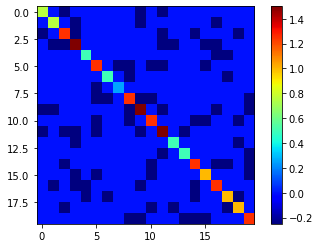

In [78]:
plt.imshow(gt_L, cmap='jet', interpolation='nearest')
plt.colorbar()
plt.show()

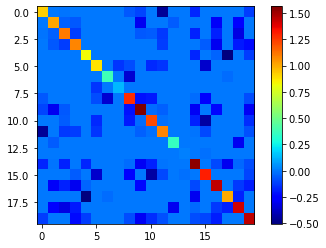

In [97]:
plt.imshow(est_L, cmap='jet', interpolation='nearest')
plt.colorbar()
plt.show()

In [100]:
Metrics.ComputeMetrics(est_L, gt_L, .01)

{'Precision': 0.5833333333333334,
 'Recall': 0.875,
 'F-Measure': 0.7000000000000001,
 'Relative Error': 0.38830560727364966,
 'SSE': 0.15078124464015785}

In [117]:
A = np.linspace(0,1,100)
B = np.linspace(1,100,100)
metrics = dict()
for a in A:
    for b in B:
        param = {'N': 20, 'max_iter':20, 'alpha':a, 'beta':b} 
        results = graph_learning_gaussian_regressor(S2, param)
        est_L = results[0]
        metrics[str(a)+ ", " + str(b)] = Metrics.ComputeMetrics(est_L, gt_L, .01)

/var/folders/67/f2dp8r654975vdx0kkbx_fmr0000gn/T/ipykernel_72661/239592756.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  arg1 = np.linalg.lstsq(temp_t, (Y_0-R))[0]
/var/folders/67/f2dp8r654975vdx0kkbx_fmr0000gn/T/ipykernel_72661/239592756.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Y = np.linalg.lstsq(temp, arg1)[0]


In [116]:
pairs = []
for a in A:
    for b in B:
        pairs.append(str(a)+ ", " + str(b)) 

In [118]:
fmeasure = [(metrics[i]['F-Measure'], i) for i in pairs]

In [121]:
fmeasure.sort()

In [129]:
print(fmeasure[len(fmeasure)-1][1])
metrics[fmeasure[len(fmeasure)-1][1]]

0.9595959595959597, 42.0


{'Precision': 0.6181818181818182,
 'Recall': 0.85,
 'F-Measure': 0.7157894736842104,
 'Relative Error': 0.4039923088489337,
 'SSE': 0.16320978560909224}

In [148]:
def f(x,y):
    return(metrics[str(x) + ", " +str(y)]['F-Measure'])

In [151]:
Z = []
for a in A:
    row = [metrics[str(a) + ', ' + str(b)]['F-Measure'] for b in B]
    Z.append(row)   
Z = np.array(Z)
Z.shape

(100, 100)

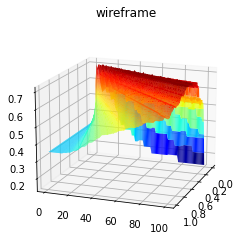

In [161]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='jet', edgecolor='none')
ax.view_init(16, 20)
ax.set_title('wireframe');